In [7]:
#!/usr/bin/env python3
# -*- encoding: utf-8 -*-

#
#   ##  DESCRIPTION ##
#   With this script, I run a simple code that recognizes
#   glithces based on the rms of the time series.
#

from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from statistics import median
from matplotlib.pyplot import figure

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print("/n /n")
# Rescaling is needed in order to let the network run.
RESCALE = 10000000
KERNEL = 1
FEATURES = 8
BATCH = 10
EPOCH = 40
DATA_SHAPE = 100

#function that loads files for the network
def load_files(filenames, category, num_categories):
    #the 1D convnet needs to specify the third axis of the tensor
    glitches = np.zeros((len(filenames), DATA_SHAPE, 1))
    category_matrix = np.zeros((len(filenames), num_categories))
    for i in range(len(filenames)):
        current_data = np.loadtxt(filenames[i])
        glitches[i,:,0] = current_data[1]
        #I save 1s on the axis for that respective category
        category_matrix[i,category] = 1
    return glitches, category_matrix

glitches, cat_glitches = load_files(glob("../Test Data/glitch/*.txt"), 0, 2)
no_glitches, cat_no_glitches = load_files(glob("../Test Data/no_glitch/*.txt"), 1, 2)

x = np.concatenate((glitches, no_glitches))
y = np.concatenate((cat_glitches, cat_no_glitches))

# traslate the data on on each median
for i in range(len(x)):
    x[i,:,0] = x[i,:,0] - median(x[i,:,0])

# rescale the data: the network gives problems with too small data.
# The rescaling is arbitrary, but it works.
for j in range(len(x)):
    for i in range(100):
        x[j,i,0] = x[j,i,0] * RESCALE


array_rms = np.zeros(100)
lowest_rms = 100
# number of blocks I divide each timeseries.
n_blocks = 7
n_times = 100
length = n_times/n_blocks

for i in range(100):
    for block in range(n_blocks):
        begin = int(length*block)
        end = int(length*(block+1))
        test_rms = np.sqrt(np.mean(np.square(x[i,begin:end,0])))
        if(test_rms > array_rms[i]):
            array_rms[i] = test_rms

    if(y[i,0] == 1):
        if(array_rms[i] < lowest_rms):
            lowest_rms = array_rms[i]

print("Threshold rms:", lowest_rms, ". \n If a timeseries has rms above this, it will be categorized as glitch.\n")


/n /n
Threshold rms: 3.0173286256984713 . 
 If a timeseries has rms above this, it will be categorized as glitch.



Text(0.5, 1.0, 'rms for the test data. \n First 50 are glitches, second 50 are non glitches.')

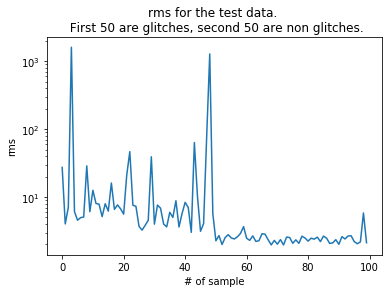

In [8]:
# Graph for the rms
plt.plot(array_rms)
plt.xlabel("# of sample")
plt.ylabel("rms")
plt.yscale('log')
plt.title("rms for the test data. \n First 50 are glitches, second 50 are non glitches.")
#plt.show()

In [9]:

# I classify the data accordingly to the rms threshold.
y_rms = np.zeros(100)
for i in range(100):
    if(array_rms[i] > lowest_rms):
        y_rms[i] = 1.0
    else:
        y_rms[i] = 0.0
print(y_rms)

# I run a permutation, in order to mix up the data
perm = np.random.permutation(x.shape[0])
# I want to have the same permutation on both x and y
np.take(x, perm, axis=0, out=x)
np.take(y, perm, axis=0, out=y)
np.take(y_rms, perm, axis=0, out=y_rms)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]


array([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.])

In [10]:
#load the neural network
my_model = models.load_model("../networks/glitch_detector.h5")

print("Neural network precision to the by-hand classification. \n")
my_model.evaluate(x,y[:,0])
print("\n \n Neural network precision to the rms classification. \n")
# I test the model with the predictions from the rms with the ones from the neural network.
my_model.evaluate(x,y_rms)
print("\n")

Neural network precision to the by-hand classification. 

100/100 [==============================] - 0s 660us/sample - loss: 0.0261 - accuracy: 1.0000

 
 Neural network precision to the rms classification. 

100/100 [==============================] - 0s 60us/sample - loss: 0.1138 - accuracy: 0.9700




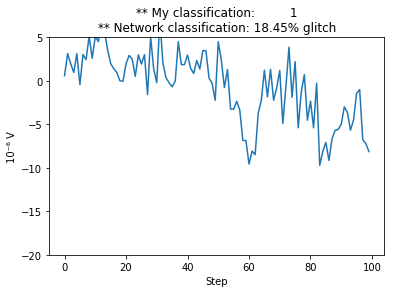

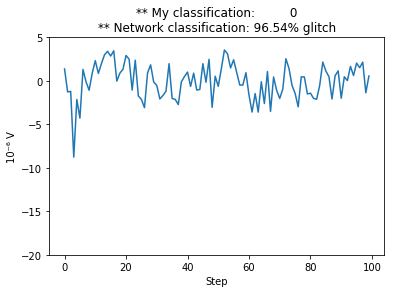

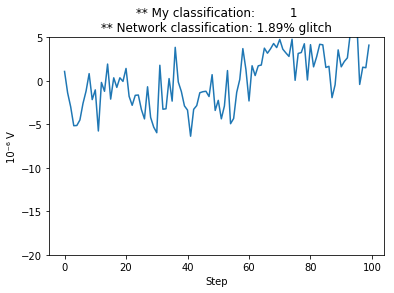

In [12]:
y_prod = my_model.predict(x)
THRESHOLD = 0.5
y_prod_2 = y_prod + THRESHOLD
for i in range(100):
    if(y_rms[i] != y_prod_2[i].astype(int)):
        plt.plot(x[i,:,0])
        plt.ylim((-20,5))
        plt.title("** My classification:         "+str(int(y_rms[i]))+"\n** Network classification: "+str(int(10000*y_prod[i])/100.)+"% glitch")
        plt.xlabel("Step")
        plt.ylabel("10⁻⁶ V")
        plt.savefig("/Users/leonardoalchieri/Desktop/SOME_PLOTS/wrong"+str(i)+".pdf")
        plt.show()